In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ebmdatalab import bq, maps, charts

In [2]:
sql= '''
SELECT
  pct,
  AVG(register_size) AS dementia_register,
  SUM(items) AS items,
  SUM(actual_cost) AS cost
FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
INNER JOIN
  ebmdatalab.hscic.qof_ccgs_1415 AS ccg
ON
  presc.pct = ccg.ccg_code
WHERE
  (bnf_code LIKE "0409010M%" OR ##Memantine
    bnf_code LIKE "0411000D0%" OR ##Donepezil
    bnf_code LIKE "0411000F0%" OR  ##Galantamine
    bnf_code LIKE "0411000E0%")
  AND (month BETWEEN TIMESTAMP('2018-01-01')
    AND TIMESTAMP('2018-12-01'))
    AND ccg.indicator_code = "DEM"
   GROUP BY
   pct
 '''

df_dementia = bq.cached_read(sql, csv_path='dementia.csv')
df_dementia.head(10)

,pct,dementia_register,items,cost
0,10D,738.0,5171,50793.62406
1,04F,1426.0,6545,51942.99091
2,00M,2414.0,13173,67129.36777
3,11X,5317.0,17252,169415.60471
4,02Q,1076.0,3897,49590.88278
5,08Y,1218.0,7538,37975.83594
6,01W,2667.0,17383,151472.34338
7,02Y,2773.0,13362,84170.13548
8,08G,1596.0,9707,44816.68623
9,09G,5491.0,41610,288545.91287


In [3]:
df_dementia['item per dem patient'] = df_dementia['items'] / df_dementia['dementia_register']
df_dementia.head(5)

,pct,dementia_register,items,cost,item per dem patient
0,10D,738.0,5171,50793.62406,7.006775
1,04F,1426.0,6545,51942.99091,4.589762
2,00M,2414.0,13173,67129.36777,5.456918
3,11X,5317.0,17252,169415.60471,3.244687
4,02Q,1076.0,3897,49590.88278,3.621747


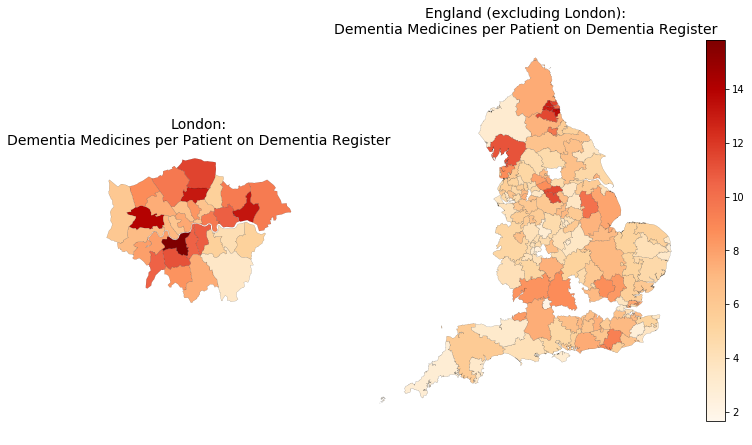

In [4]:
plt.figure(figsize=(12, 7))
maps.ccg_map(df_dementia, title="Dementia Medicines per Patient on Dementia Register", column='item per dem patient', 
             separate_london=True)
plt.savefig('map.png', format='png', dpi=300,bbox_inches='tight')
plt.show()